In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
import tensorflow as tf
import os
%matplotlib inline

In [156]:
train = pd.read_csv('train_solution_bounding_boxes(1).csv')
train

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [4]:
def random_selection(df=train, path='training_images/'):
    rand_idx = np.random.randint(0, df.shape[0] - 1)
    row = df.loc[rand_idx, :]
    image = cv2.imread(str(path + row['image'])) / 255.
    bounding_box_coordinates = np.array(row[['xmin', 'ymin', 'xmax', 'ymax']], dtype=np.float32)
    return image, bounding_box_coordinates

In [5]:
def data_loader(batch_size=16, df=train, path='training_images/'):
    while True:
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_boxes = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
            image, bounding_box = random_selection(df=train, path=path)
            
            images[i] = image
            bounding_boxes[i] = bounding_box
        
        yield {'images': images}, {'bounding_boxes': bounding_boxes}

[ 16.63097    199.75064087 105.16642761 238.38642883]


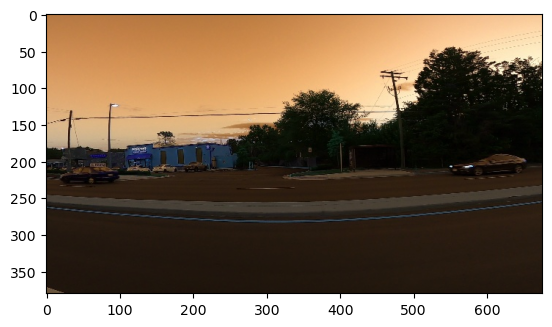

In [7]:
images, bboxs = next(data_loader(batch_size=1))
image = images['images'][0]
bounding_box = bboxs['bounding_boxes'][0]
plt.imshow(image)
print(bounding_box)

In [10]:
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense
from keras import layers, models

input_ = Input(shape=[380,676,3], name = 'images')
x = layers.Flatten()(input_)
x = layers.Dense(256, activation = 'relu')(x)
output = layers.Dense(4, name = 'bounding_boxes')(x)

model = models.Model(inputs = input_, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 images (InputLayer)         [(None, 380, 676, 3)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 770640)            0         
                                                                 
 dense_1 (Dense)             (None, 256)               197284096 
                                                                 
 bounding_boxes (Dense)      (None, 4)                 1028      
                                                                 
Total params: 197,285,124
Trainable params: 197,285,124
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(
    loss={
        'bounding_boxes': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'bounding_boxes': 'accuracy'
    }
)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
history = model.fit(data_loader(), epochs = 12, steps_per_epoch = 100)

Epoch 1/12
100/100 [==============================] - 454s 4s/step - loss: 34327.7344 - acc: 0.6181
Epoch 2/12
100/100 [==============================] - 186s 2s/step - loss: 19810.5293 - acc: 0.6875
Epoch 3/12
100/100 [==============================] - 150s 2s/step - loss: 17708.8828 - acc: 0.6837
Epoch 4/12
100/100 [==============================] - 135s 1s/step - loss: 16882.8242 - acc: 0.6675
Epoch 5/12
100/100 [==============================] - 127s 1s/step - loss: 16166.9785 - acc: 0.6956
Epoch 6/12
100/100 [==============================] - 204s 2s/step - loss: 15779.7021 - acc: 0.7081
Epoch 7/12
100/100 [==============================] - 186s 2s/step - loss: 15083.0312 - acc: 0.7063
Epoch 8/12
100/100 [==============================] - 161s 2s/step - loss: 13943.2275 - acc: 0.7369
Epoch 9/12
100/100 [==============================] - 147s 1s/step - loss: 14171.1680 - acc: 0.7419
Epoch 10/12
100/100 [==============================] - 183s 2s/step - loss: 13468.0195 - acc: 0.7694

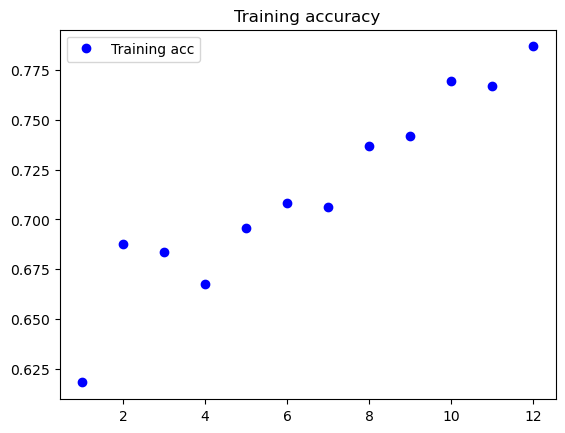

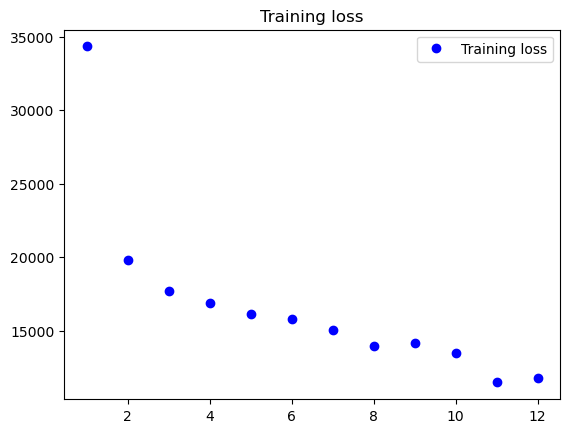

In [152]:
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [17]:
model.save('car_detection.h5')

In [75]:
def random_selection_test(path='testing_images/'):
    row = os.listdir(path)
    rand_idx = np.random.randint(len(row))
    image = cv2.imread(path + row[rand_idx]) / 255.
    return image

In [83]:
def data_loader_test(batch_size=1, path='testing_images/'):
    while True:
        images = np.zeros((batch_size, 380, 676, 3))
        
        for i in range(batch_size):
            image = random_selection_test(path=path)
            
            images[i] = image
        
        yield {'images': images}

In [173]:
images = next(data_loader_test(batch_size=1))
image = images['images'][0]
predictions = model.predict(images)
cv2.rectangle(image, (int(predictions[0][0]), int(predictions[0][1])), (int(predictions[0][2]), int(predictions[0][3])), (255,0,0), 2)
plt.imshow(image)

1/1 [==============================] - 0s 313ms/step
